In [1]:
import dicom
from numpy import *
import SimpleITK as sitk
import os


def read_ct_scan(path, verbose=False):
    # type: (object) -> object
    # Read the slices from the dicom file
    slices = []
    if os.path.isfile(path):
        try:
            return sitk.ReadImage(path)
        except:
            if verbose:
                print('Neither a DICOM nor a MHD file: %s' % os.path.basename(path))

    if os.path.isdir(path):
        files = os.listdir(path)
        for filename in files:
            try:
                slices.append(dicom.read_file(os.path.join(path, filename)))
            except dicom.filereader.InvalidDicomError:
                if verbose:
                    print('Neither a DICOM nor a MHD file: %s' % filename)

        slices.sort(key=lambda x: int(x.InstanceNumber))

        try:
            slice_thickness = abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
        except AttributeError:
            slice_thickness = abs(slices[0].SliceLocation - slices[1].SliceLocation)

        for s in slices:
            s.SliceThickness = slice_thickness

        return slices


def extract_array(ct_scan):
        heights = asarray([int(ct_slice.SliceLocation)for ct_slice in ct_scan])
        ct_scan = stack([ct_slice.pixel_array for ct_slice in ct_scan])
        ct_scan[ct_scan == -2000] = 0
        return ct_scan, heights


def get_pixels_hu(slices):
    try:
        image = stack([s.pixel_array for s in slices])
    except AttributeError:
        return sitk.GetArrayFromImage(slices)
    # Convert to int16 (from sometimes int16),
    # should be possible as values should always be low enough (<32k)
    image = image.astype(int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0

    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):

        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope

        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(float64)
            image[slice_number] = image[slice_number].astype(int16)

        image[slice_number] += int16(intercept)

    return array(image, dtype=int16)


def read_ct(path):
    patient = read_ct_scan(path)
    patient = get_pixels_hu(patient)
    return patient

In [3]:
import numpy as np
from scipy.ndimage.filters import gaussian_filter

def gaussian_curvature(Z):
    Zy, Zx = np.gradient(Z)                                                     
    Zxy, Zxx = np.gradient(Zx)                                                  
    Zyy, _ = np.gradient(Zy)                                                    
    K = (Zxx * Zyy - (Zxy ** 2)) /  (1 + (Zx ** 2) + (Zy **2)) ** 2
    H = (Zxx * (1 + Zy ** 2) - 2 * Zxy * Zx * Zy + Zyy * (1 + Zx ** 2)) / (2 * (1 + Zx ** 2 + Zy ** 2)) ** (3/2)
    return K,H


def SI_CV(im):
    K,H = gaussian_curvature(im)
    k1 = H + (H ** 2 - K) ** 0.5
    k2 = H - (H ** 2 - K) ** 0.5
    SI = 2 / np.pi * np.arctan((k1 + k2) / (k1 - k2))
    CV = (k1 ** 2 + k2 ** 2) ** 0.5
    return SI, CV


coords = []
filtered = []
patient = read_ct('../../../data/LUNA/DATA/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd')#1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd1.3.6.1.4.1.14519.5.2.1.6279.6001.927394449308471452920270961822.mhd')
for im in patient:
    blurred = gaussian_filter(im, sigma=1)
    SI, CV = SI_CV(blurred)
    coords.append(np.where( (SI > 0.77) & (CV > 0.75) ) )
    filtered.append((SI > 0.77) & (CV > 0.75))

/home/a.dobrenkii/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in sqrt
/home/a.dobrenkii/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in sqrt
/home/a.dobrenkii/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in true_divide
/home/a.dobrenkii/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:28: RuntimeWarning: invalid value encountered in greater
/home/a.dobrenkii/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in greater
/home/a.dobrenkii/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in true_divide


In [22]:
a = asarray(filtered)
a_show = binary_dilation(a,iterations=1)

In [23]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [24]:
from scipy.ndimage.morphology import binary_dilation

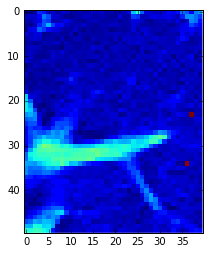

In [53]:
plt.imshow((asarray(filtered)*2000+patient)[60,200:250,360:400],interpolation='none')

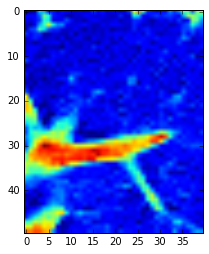

In [51]:
plt.imshow((patient)[60,200:250,360:400])